In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
ids_to_labels = {0: 'Ｘ', 1: 'Ｏ', 2: 'Ｖ', -100:'IGN'}
labels_to_ids = {'Ｘ': 0, 'Ｏ': 1, 'Ｖ':2,  'IGN':-100}

In [4]:
ids_to_labels

{0: 'Ｘ', 1: 'Ｏ', 2: 'Ｖ', -100: 'IGN'}

In [5]:
labels_to_ids

{'Ｘ': 0, 'Ｏ': 1, 'Ｖ': 2, 'IGN': -100}

In [6]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 1
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('cl-tohoku/bert-large-japanese')

In [7]:
with open('Noni_data_ipa_all_tag.txt', 'r') as filein:
    wiki_tag = filein.readlines()
    filein.close()

In [8]:
wiki_tag_all = [''.join(wiki_tag[i].strip()) for i in range(len(wiki_tag))]

In [9]:
wiki_tag_all[:4]

['ＸＸＸＸＸＸＸＸＸＸＯＯＯＯＯＯＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＯＯＯＯＯＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＯＯＯＯＯＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ',
 'ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＯＯＯＯＯＯＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ']

In [10]:
from sklearn.model_selection import train_test_split
jp_train_tag, jp_test_tag = train_test_split(wiki_tag_all, random_state=55, train_size=0.7)

In [11]:
len(jp_train_tag)

17500

In [12]:
cnt = 0
for word in jp_train_tag:
    if 'Ｏ' in word:
        cnt = cnt+1
print(cnt)   

4370


In [13]:
cnt = 0
for word in jp_train_tag:
    if 'Ｖ' in word:
        cnt = cnt+1
print(cnt)   

4337


In [14]:
len(jp_test_tag)

7500

In [15]:
cnt = 0
for word in jp_test_tag:
    if 'Ｏ' in word:
        cnt = cnt+1
print(cnt)   

1880


In [16]:
cnt = 0
for word in jp_test_tag:
    if 'Ｖ' in word:
        cnt = cnt+1
print(cnt)   

1913


In [17]:
with open('Noni_data_ipa_all.txt', 'r') as filein:
    wiki_sent = filein.readlines()
    filein.close()

In [18]:
wiki_sent_all = [wiki_sent[i].strip() for i in range(len(wiki_sent))]

In [19]:
jp_train_texts, jp_test_texts = train_test_split(wiki_sent_all, random_state=55, train_size=0.7)

In [20]:
wiki_sent_all[:4]

['また、逆に、係助詞を使わないのに文末が連体形で結ばれる例も多くなってくる。',
 '日本の蘚苔類学会のある年に行なわれた観察会では、山間部の渓谷にコースを設定してあったのにその入り口の駐車場周辺だけで1日を過ごしてしまったとの伝説がある。',
 '彼はそこで、（後に弟子のプラトンがオルペウス教（ピタゴラス教団）的な輪廻転生説に嵌っていくのとは対照的に）死後のことについては一切わからないという不可知論の立場を採る（死刑確定前の弁明においても、「死後のことを知っている者など誰もいないのに人々はそれを最大の悪であるかのように恐れる。',
 'これを自動化することは、技術的には可能であるが、セキュリティの確保と利便性の向上は常にトレードオフの関係になり、ちょうど良い頃合いを見定めるのにしばらく時間がかかりそうである。']

In [21]:
text = []
for num in range(len(wiki_sent_all)):
    text.append(len(wiki_sent_all[num]))

                  0
count  25000.000000
mean      54.886480
std       43.239797
min        2.000000
25%       26.000000
50%       41.000000
75%       71.000000
max      682.000000


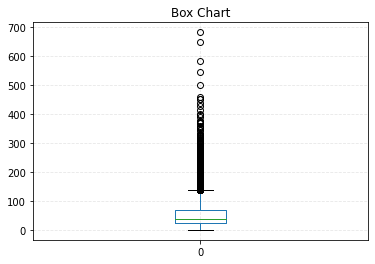

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# data = [1, 2, 3, 4, 5, 6, 7, 8]

df = pd.DataFrame(text)
print(df.describe())
df.plot.box(title="Box Chart")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [22]:
text = []
for num in range(len(wiki_sent_all)):
    text.append(len(wiki_sent_all[num]))

In [21]:
jp_train_texts[0]

'そうした中で、比定の大きな根拠となっていた『神護寺略記』と「大英博物館本源頼朝像」は、神護寺三像との関係は否定されているのに像主名だけは変更されずにいる不条理を指摘する。'

In [22]:
tokenizer(wiki_sent_all[0])

{'input_ids': [2, 11168, 828, 5215, 893, 828, 1191, 1427, 4896, 932, 1169, 929, 14860, 6462, 6416, 2686, 2827, 861, 5231, 1153, 2271, 888, 4176, 897, 11304, 1174, 916, 1842, 865, 12241, 6632, 25327, 829, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## 檢查是否有None

In [23]:
for i in range(len(wiki_sent_all)):
    data_sent =[wiki_sent_all[i][word] for word in range(len(wiki_sent_all[i]))]
    data_label =[wiki_tag_all[i][word] for word in range(len(wiki_tag_all[i]))]
    pd.set_option('display.max_columns', None)
    if len(wiki_sent_all[i]) == len(wiki_tag_all[i]):
#         print(i,'OK')
        continue
    else:
        df = pd.DataFrame([data_sent, data_label], index=["sent", "label"])
        print(i)

In [166]:
wiki_sent_all[8000:8002]

['パークゴルフ場で風の強さや向きを知るのに使われている。',
 '当該歓楽街の中心的客層が、深夜割増料金タクシーで自宅に帰るのに必要な金額とほぼ同じかやや安く中心価格帯が設定されている。']

In [29]:
sent_try = [wiki_sent_all[457][word] for word in range(len(wiki_sent_all[457]))]
label_try = [wiki_tag_all[457][word] for word in range(len(wiki_tag_all[457]))]
df = pd.DataFrame([sent_try, label_try], index=["sent", "label"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
sent,能,力,と,才,能,が,足,ら,な,い,の,に,強,い,て,他,人,の,働,き,に,頼,る,。
label,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [64]:
df.fillna('Ｘ')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213
sent,こ,の,結,果,、,例,え,ば,旧,暦,で,は,「,秋,」,で,あ,っ,た,「,文,月,（,7,月,）,」,が,新,暦,で,は,「,夏,」,に,な,っ,た,り,、,7,月,9,日,頃,か,ら,8,月,1,1,日,頃,ま,で,で,あ,っ,た,二,百,十,日,が,新,暦,9,月,1,日,に,な,っ,た,り,、,盆,の,節,会,を,行,う,時,期,が,地,域,に,よ,っ,て,新,暦,7,月,と,新,暦,8,月,に,別,れ,た,り,す,る,な,ど,、,月,遅,れ,に,よ,る,そ,れ,ま,で,の,慣,習,と,の,相,違,が,発,生,し,て,い,る,ほ,か,、,前,記,の,よ,う,な,元,々,の,中,国,風,の,定,義,も,絡,み,、,現,在,で,も,若,干,の,違,和,感,が,存,在,す,る,こ,と,か,ら,、,日,本,の,メ,デ,ィ,ア,で,は,「,暦,の,上,で,は,…,…,」,\t,と,前,置,き,し,て,説,明,さ,れ,る,こ,と,が,あ,る,。
label,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [65]:
with open('check_Tari.txt', 'w') as fileout:
    for i in range(len(wiki_sent_all)):
        data_sent =[wiki_sent_all[i][word] for word in range(len(wiki_sent_all[i]))]
        data_label =[wiki_tag_all[i][word] for word in range(len(wiki_tag_all[i]))]
        pd.set_option('display.max_columns', None)
        dd = pd.DataFrame([data_sent, data_label], index=["sent", "label"])
        df = dd.fillna('Ｘ')
        answer = ''.join(df.loc['label'])
        fileout.write(answer+'\n')
fileout.close()

KeyboardInterrupt: 

---

In [18]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
#         sentence = self.data.sentence[index].strip().split()
        sentence = [i for i in self.data.sentence[index]]
#         word_tag_n = [''.join(label) for label in word_labels[index]]
#         word_labels = self.data.word_labels[index].split() 
    
        word_labels = [j for j in self.data.word_labels[index]]    


        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_pretokenized=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 

        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

    def __len__(self):
        return self.len

In [19]:
train_dataset = pd.DataFrame([jp_train_texts, jp_train_tag], index=["sentence", "word_labels"]).T
test_dataset = pd.DataFrame([jp_test_texts, jp_test_tag], index=["sentence", "word_labels"]).T

In [20]:
train_dataset[555:570]

,sentence,word_labels
555,2019年3月16日ダイヤ改正より、東村山駅周辺の高架化工事に伴い、国分寺線で運用する車両の...,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ...
556,だから、大人でも子供でもただ一度この機械を回わればすぐ引かれるようになった。,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ
557,*2014年2月13日石川県警本部公安課の巡査部長が酒を飲んで当て逃げを起こしていたのに県警...,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＯＯＯＯＸＸ...
558,新学期が始まった。,ＸＸＸＸＸＸＸＸＸ
559,29歳の私は高層ビルにいて、窓から外を見ています。,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ
560,焼き畑農業のような最も原始的な農業でも、棒きれのようなものが農具として使われ、土を掘り返すの...,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＶＶＶＶＶ...
561,緊急援助が行き渡るのにしたがって、次第に活動範囲を広げて1953年に正式名称が現在のものに変...,ＸＸＸＸＸＶＶＶＶＶＶＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ...
562,1回切るのに5分かかり、1回切るごとに1分休憩すると、何分で切れるか。,ＸＸＶＶＶＶＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ
563,同じ奨学金を取得するのにケベック州民の学生は、CEGEPRスコアは最低35.5が要求される。,ＸＸＸＸＸＸＸＸＯＯＯＯＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ
564,幼い頃から寡黙で、母が病がちだったため祖父母の許で育ったが、両親の許に戻った後は気を使ってい...,ＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸＸ...


In [21]:
print("のに型 TRAIN Dataset: {}".format(train_dataset.shape))
print("のに型 TEST Dataset: {}".format(test_dataset.shape))
training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

のに型 TRAIN Dataset: (17500, 2)
のに型 TEST Dataset: (7500, 2)


In [22]:
training_set[0]

{'input_ids': tensor([   2,  879,  856,  873,  881, 1052,  888,  828, 3127, 1985,  896, 1846,
          863,  892, 2914, 2527,  890,  892,  885,  888,  854,  881,  840, 3918,
         4989, 2029, 3712, 4874,  841,  890,  838, 1846, 4518, 1493, 3539, 5729,
         2828, 3324, 5685, 2821, 1266,  839,  897,  828, 3918, 4989, 2029, 1036,
         1266,  890,  896, 5493, 1191,  897, 1574, 1985,  871,  926,  888,  854,
          925,  896,  893, 1266, 1056, 1564,  881,  867,  897, 1836, 2801,  871,
          926,  875,  893,  854,  925, 1039, 2848, 3614,  932, 2543, 2618,  875,
          925,  829,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [23]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
    print('{0:10}  {1}'.format(token, label))

[CLS]       -100
そ           0
う           0
し           0
た           0
中           0
て           0
、           0
比           0
定           0
の           0
大           0
き           0
な           0
根           0
拠           0
と           0
な           0
っ           0
て           0
い           0
た           0
『           0
神           0
護           0
寺           0
略           0
記           0
』           0
と           0
「           0
大           0
英           0
博           0
物           0
館           0
本           0
源           0
頼           0
朝           0
像           0
」           0
は           0
、           0
神           0
護           0
寺           0
三           0
像           0
と           0
の           0
関           0
係           0
は           0
否           0
定           0
さ           0
れ           0
て           0
い           1
る           1
の           1
に           1
像           0
主           0
名           0
た           0
け           0
は           0
変           0
更           0
さ  

In [24]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params) ## **表示字典 一批取4
testing_loader = DataLoader(testing_set, **test_params)

In [25]:
model = BertForTokenClassification.from_pretrained('cl-tohoku/bert-large-japanese', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [26]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(0.9838, device='cuda:0', grad_fn=<NllLossBackward0>)

In [27]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 4])

In [28]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)

In [34]:
import warnings
warnings.filterwarnings('ignore')
# Defining the training function on the 80% of the dataset for tuning the bert model,
def train(epoch):
    tr_loss, tr_accuracy, tr_opt_acc = 0, 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_opt_zero_steps, tr_opt_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader): # 一次取一批
#         print(idx)
#         if idx == 193:
#             print(batch['input_ids'])
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels) ## 輸入 算出損失值
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

#         if idx % 100==0:
#             loss_step = tr_loss/nb_tr_steps
#             print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,) ## 算每一批預測值

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
        
        tn, fo, fv, fn, to, fv2, fn2, fo2, tv = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1, 2]).ravel()
        tmp_tr_opt_acc = (to+tv)/(fo+fv+fn+fv2+fn2+fo2+to+tv)
        if np.isnan(tmp_tr_opt_acc) == True:
            tmp_tr_opt_acc = 1
            tr_opt_zero_steps += 1
        else:
            tr_opt_steps += 1
            tr_opt_acc += tmp_tr_opt_acc            
            
            if idx % 100==0:
                loss_step = tr_loss/nb_tr_steps
                print(f"Training loss per 100 training steps: {loss_step}")
                opt_acc_step = tr_opt_acc / tr_opt_steps
                print(f"Training Opt_acc epoch: {opt_acc_step}")
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad() ## T度值 清空
        loss.backward() ## 反向回饋"修正權重"
        optimizer.step() ## 透過優化器(先算損失值得反向回饋)執行修正

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    tr_opt_acc = tr_opt_acc / tr_opt_steps
    
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    print(f"Training Opt_acc epoch: {tr_opt_acc}")
    print('tr_zero_steps:',tr_opt_zero_steps)
    print('tr_opt_steps:',tr_opt_steps)

In [35]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 0.007747213821858168
Training Opt_acc epoch: 1.0
Training loss per 100 training steps: 0.009488284386042333
Training Opt_acc epoch: 0.916702062712701
Training loss per 100 training steps: 0.011147295359831387
Training Opt_acc epoch: 0.9255767550842396
Training loss per 100 training steps: 0.010364967423164704
Training Opt_acc epoch: 0.9300504925553807
Training loss per 100 training steps: 0.011880030902299457
Training Opt_acc epoch: 0.9178325607549317
Training loss per 100 training steps: 0.01093976528789938
Training Opt_acc epoch: 0.9221632837936938
Training loss per 100 training steps: 0.011915411441445024
Training Opt_acc epoch: 0.9190874968844228
Training loss per 100 training steps: 0.01124170451168977
Training Opt_acc epoch: 0.9245832434810457
Training loss per 100 training steps: 0.01224364222060571
Training Opt_acc epoch: 0.9219462239503079
Training loss per 100 training steps: 0.01233806135741392
Training Opt_acc epoch: 0

In [40]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy, eval_precision, eval_f1, eval_recall, eval_opt_acc, eval_opt_acc_n = 0, 0, 0, 0, 0, 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    opt_zero_steps, opt_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels) #模型預測+算損失值

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

#             if idx % 100==0:
#                 loss_step = eval_loss/nb_eval_steps
#                 print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels) 遮罩 不會取無用
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,) 取最大機率的標記 num_label就消失 每批有效字元標記

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
#             tmp_eval_precision = precision_score(labels.cpu().numpy(), predictions.cpu().numpy())
#             tmp_eval_f1 = f1_score(labels.cpu().numpy(), predictions.cpu().numpy())
#             tmp_eval_recall = recall_score(labels.cpu().numpy(), predictions.cpu().numpy())
#             tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1]).ravel()
#             tmp_eval_opt_acc = tp/(fn+fp+tp)
            tn, fo, fv, fn, to, fv2, fn2, fo2, tv = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1, 2]).ravel()
            tmp_eval_opt_acc = (to+tv)/(fo+fv+fn+fv2+fn2+fo2+to+tv)
            
            if np.isnan(tmp_eval_opt_acc) == True:
                tmp_eval_opt_acc = 1
                opt_zero_steps += 1
#                 print('opt_zero_steps:',opt_zero_steps)
            else:
                opt_steps += 1
                eval_opt_acc_n += tmp_eval_opt_acc
                
                if idx % 100==0:
                    loss_step = eval_loss/nb_eval_steps
                    print(f"Validation loss per 100 evaluation steps: {loss_step}")
                    opt_acc_step = eval_opt_acc_n / opt_steps
                    print(f"Validation Opt_acc epoch: {opt_acc_step}")
                
#             print(tn, fp, fn, tp)
#             print(tmp_eval_opt_acc)
#             print(labels.cpu().numpy(), predictions.cpu().numpy())
#             print('labels:',labels.cpu().numpy())
#             print('prediction:',predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
#             eval_precision += tmp_eval_precision
#             eval_f1 += tmp_eval_f1
#             eval_recall += tmp_eval_recall
#             eval_opt_acc += tmp_eval_opt_acc

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    print(eval_opt_acc_n)
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
#     eval_precision = eval_precision / nb_eval_steps
#     eval_f1 = eval_f1 / nb_eval_steps
#     eval_recall = eval_recall / nb_eval_steps
#     eval_opt_acc = eval_opt_acc / nb_eval_steps
    eval_opt_acc_n = eval_opt_acc_n / opt_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
#     print(f"Validation Precision: {eval_precision}")
#     print(f"Validation F1: {eval_f1}")
#     print(f"Validation Recall: {eval_recall}")
#     print(f"Validation Opt_Acc: {eval_opt_acc}")
    print(f"Validation Opt_Acc_n: {eval_opt_acc_n}")
    print('zero_steps:',opt_zero_steps)
    print('opt_steps:',opt_steps)
    

    return labels, predictions

In [41]:
import warnings
warnings.filterwarnings("ignore")
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.009141453203261533
Validation Opt_acc epoch: 0.9205154877484976
Validation loss per 100 evaluation steps: 0.00932039673693832
Validation Opt_acc epoch: 0.9261605271039234
Validation loss per 100 evaluation steps: 0.009205232507021375
Validation Opt_acc epoch: 0.9269257703081232
Validation loss per 100 evaluation steps: 0.008141942591260385
Validation Opt_acc epoch: 0.9360164835164836
Validation loss per 100 evaluation steps: 0.00824483796662346
Validation Opt_acc epoch: 0.9361904761904762
Validation loss per 100 evaluation steps: 0.009177730164347857
Validation Opt_acc epoch: 0.9344241079682013
Validation loss per 100 evaluation steps: 0.009143626024518273
Validation Opt_acc epoch: 0.936499582289056
Validation loss per 100 evaluation steps: 0.009998250525713386
Validation Opt_acc epoch: 0.935031293105223
Validation loss per 100 evaluation steps: 0.010037156889316
Validation Opt_acc epoch: 0.9343228637114834
Validation loss per 100 evaluation 

In [46]:
# import warnings
# warnings.filterwarnings("ignore")
# labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 5.2315403991087805e-06
Validation loss per 100 evaluation steps: 0.0051576542535647805
Validation loss per 100 evaluation steps: 0.008994274023082052
Validation loss per 100 evaluation steps: 0.009179425629381708
Validation loss per 100 evaluation steps: 0.009211852786256344
Validation loss per 100 evaluation steps: 0.008786174003366815
Validation loss per 100 evaluation steps: 0.007905135659207651
Validation loss per 100 evaluation steps: 0.008813488478926745
Validation loss per 100 evaluation steps: 0.007814253564141779
Validation loss per 100 evaluation steps: 0.00806316829391777
Validation loss per 100 evaluation steps: 0.008348489976179912
Validation loss per 100 evaluation steps: 0.008557843492716722
Validation loss per 100 evaluation steps: 0.008923472931435814
Validation loss per 100 evaluation steps: 0.009024817274739074
Validation loss per 100 evaluation steps: 0.010040913569460736
Validation loss per 100 evaluation steps: 0.009608210

---

## 讀檔

In [22]:
import torch
device = torch.device("cuda")
model = BertForTokenClassification.from_pretrained('cl-tohoku/bert-large-japanese', num_labels=len(labels_to_ids))
# model.to(device)
model1 = model.load_state_dict(torch.load('model_Noni/pytorch_model.bin'))
model1 = model.to(device)
model1 = model.eval()

Some weights of the model checkpoint at cl-tohoku/bert-large-japanese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

In [23]:
tokenizer = BertTokenizerFast.from_pretrained('cl-tohoku/bert-large-japanese')

---

L８—３ -> 應為Ｖ
Ｖ彼がその本を読むのに4日かかるでしょう。
Ｖ車を修理するのに１万円かかった。
Ｖ名古屋から東京まで行くのに2時間かかった。
Ｖ私がそのパズルを解くのに2時間かかりました。
Ｖ学校に来るのにどれくらい時間がかかりますか。
Ｏ卒論作るのにどれくらいかかったかを教えてください。
Ｏ日本に留学するのにいくらかかりましたか？
.Ｖお互いを理解するのに時間が必要です。
 
L２１—２ -> 應為Ｏ
Ｏバスを1時間も待っているのに、まだ来ません。
Ｏ両親がとても心配しているのに、うちに電話をしませんでした。
Ｏ毎日薬を飲んでいるのに、なかなかよくなりません。
Ｏ毎日勉強しているのに、なかなか覚えることができません。
Ｏワンさんは約束したのに、来ませんでした。
Ｏお金が入れたのに、ジュースが出ません。
Ｏタクシーで来たのに、間に合いませんでした。
Ｏこの料理は、砂糖を入いれていないのに甘い。

In [27]:
sentence = "日本に留学するのにいくらかかりましたか？"

inputs = tokenizer([word for word in sentence],
                    is_pretokenized=True, 
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
        prediction.append(token_pred[1])
    else:
        continue

# print(sentence.split())
print([word for word in sentence])
# print(inputs['input_ids'])
print(prediction)

['日', '本', 'に', '留', '学', 'す', 'る', 'の', 'に', 'い', 'く', 'ら', 'か', 'か', 'り', 'ま', 'し', 'た', 'か', '？']
['Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｏ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ', 'Ｘ']


In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame([[word for word in sentence], prediction], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,日,本,に,留,学,す,る,の,に,い,く,ら,か,か,り,ま,し,た,か,？
Tags,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｏ,Ｏ,Ｏ,Ｏ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ,Ｘ


In [44]:
inputs

{'input_ids': tensor([[   2, 2719, 2828,  893, 3705, 1967,  875,  925,  896,  893,  854,  865,
          923,  861,  861,  924,  912,  873,  881,  861,    1,    3,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0,

In [45]:
import os

directory = "./model_Noni"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
